# Treinamento de Rede Neural com SNR aleatório

## QAM Rayleigh

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from libs.commpy_mod import SISOFlatChannel

from files_01_detection.const_mod import generate_symbols, Model
from files_01_detection.const_analyzer import plot_decision_boundary, theoretical_error, ser, plot_confusion_matrix, plot_symbols
 
%matplotlib inline

2023-04-10 10:58:58.406335: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-10 10:58:59.556184: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-10 10:58:59.556251: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-10 10:58:59.815246: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-10 10:59:02.245317: W tensorflow/stream_executor/platform/de

In [2]:
total_num_symbols  = 1000000    # Number of transmitted symbols to be used for training and test
train_fraction = 0.7 # Fraction of whole data to be used for training (the remaining is for testing)
code_rate    = 1       # Rate of the used code
Es           = 1       # Average symbol energy
Mod = 'QAM'
channel_type = 'rayleigh' # 'awgn' or 'crazy'
M            = 16      # PSK modulation

In [29]:
error_rate = ([error(int(200 / (Teo_SNRs[int(i / passo)] * np.log2(M))), model_QAM[0], Mod, M, channel_type, Es, code_rate, [init_scale + i]) for i in range(1)]) / (tf.math.log(float(M))/tf.math.log(2.))

[0.7014218]


In [3]:
def error(amostras, model, mod, M, channel_type, Es, code_rate, snr):
    frac = 10000
    error = 0
    a = amostras
    for i in range(amostras // frac + 1):
        if a < frac:
            frac = amostras % frac
        sub_amostras =  conjunto(Mod, frac, M, channel_type, Es, code_rate, snr, False, scaler.transform)
        error += ser(model, tf.reshape(tf.convert_to_tensor(sub_amostras[0]), [-1, 3]),
                          tf.reshape(tf.convert_to_tensor(sub_amostras[1]), [-1, 1]), nn=True)
        a -= frac
    error /= amostras / frac
    return error


In [4]:
def conjunto(Mod, total_num_symbols, M, channel_type, Es, code_rate, SNR_dB, symb=False, scaler=None):

    symbs, indices, channel_output = Model(Mod, total_num_symbols, M, channel_type, Es, code_rate, [SNR_dB[0]])
    x = np.stack([np.real(channel_output[0][:]),
                    np.imag(channel_output[0][:])], axis=1)

    if scaler is not None:
        x = scaler(np.concatenate((x, np.array([channel_output[1]]).T), axis=1))
    else:
        x = np.concatenate((x, np.array([channel_output[1]]).T), axis=1)
    
    x = x.reshape(1,-1,3)
    
    for i in range(1, len(SNR_dB)):
        a, b, c = Model(Mod, total_num_symbols, M, channel_type, Es, code_rate, SNR_dB[i])
        
        d = np.stack([np.real(c[0][:]), np.imag(c[0][:])], axis=1)
        
        if scaler is not None:
            d = scaler(np.concatenate((d, np.array([c[1]]).T), axis=1))
        else:
            d = np.concatenate((d, np.array([c[1]]).T), axis=1)
        
        symbs = np.vstack((symbs, a))
        indices = np.vstack((indices, b))
        channel_output = np.vstack((channel_output, c))
        x = np.vstack((x, d.reshape(1,-1,3)))
    
    y = np.float_(indices)
        
    if symb:
        return x, y, symbs
    else:
        return x, y

In [5]:
def Train_Data(Mod, total_num_symbols, M, channel_type, Es, code_rate, min, max):

    symbs, indices, channel_output = Model(Mod, total_num_symbols, M, channel_type, Es, code_rate, [min, max])
    x = np.stack([np.real(channel_output[0][:]),
                    np.imag(channel_output[0][:])], axis=1)
    x = np.concatenate((x, np.array([np.real(channel_output[1])]).T), axis=1)
    
    y = np.float_(indices[0])
    
    return x, y, symbs
"""
    indices = np.array([])
    symbs = np.array([])
    channel_output = np.array([])
    alpha = np.array([])
    for i in range(total_num_symbols):
        a, b, c = Model(Mod, 1, M, channel_type, Es, code_rate, np.random.randint(min, max))
        symbs = np.append(symbs, a)
        indices = np.append(indices, b)
        channel_output = np.append(channel_output, c[0])
        alpha = np.append(alpha, c[1])
        
    x = np.stack([np.real(channel_output[:]),
                        np.imag(channel_output[:])], axis=1)
    x = np.concatenate((x, np.array([alpha]).T), axis=1)
    
    y = np.float_(indices)
"""

'\n    indices = np.array([])\n    symbs = np.array([])\n    channel_output = np.array([])\n    alpha = np.array([])\n    for i in range(total_num_symbols):\n        a, b, c = Model(Mod, 1, M, channel_type, Es, code_rate, np.random.randint(min, max))\n        symbs = np.append(symbs, a)\n        indices = np.append(indices, b)\n        channel_output = np.append(channel_output, c[0])\n        alpha = np.append(alpha, c[1])\n        \n    x = np.stack([np.real(channel_output[:]),\n                        np.imag(channel_output[:])], axis=1)\n    x = np.concatenate((x, np.array([alpha]).T), axis=1)\n    \n    y = np.float_(indices)\n'

In [24]:
x_out, y_out, symbs = Train_Data(Mod, total_num_symbols, M, channel_type, Es, code_rate, 5, 30)

In [6]:
x_out = np.fromfile('Random_Data/SNR_8-12/Rayleigh/16-QAM/x_rand.dat', dtype=np.dtype('float64')).reshape((-1,3))
y_out = np.fromfile('Random_Data/SNR_8-12/Rayleigh/16-QAM/y_rand.dat', dtype=np.dtype('float64'))
symbs = np.fromfile('Random_Data/SNR_8-12/Rayleigh/16-QAM/symb.dat', dtype=np.dtype('complex128')).reshape((1,-1))

In [7]:
# Generate dataset
# Train
train_size = int(train_fraction*total_num_symbols) #data used for training
y_train = y_out[:train_size]
X_train = x_out[:train_size]

# Test
y_test = y_out[train_size:]
X_test = x_out[train_size:]

scaler = StandardScaler()
scaler.fit(X_train)  # Don't cheat - fit only on training data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


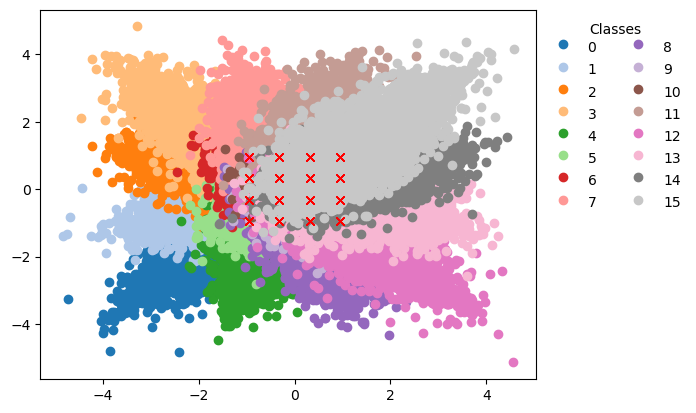

In [7]:
plot_symbols(X_train, y_train, M, symbs)

## Criação e treinamento da Rede Neural

In [8]:
n_inputs = np.shape(X_train)[1]

In [9]:
n_redes = 3
n_hidden = [[150, 80, 50],
            [300, 180, 90, 40],
            [500, 380, 240, 135, 80]]

n_outputs = M
learning_rate = [0.01, 0.01, 0.001]
n_epochs = [50, 50, 50]
batch_size = [8000, 16000, 24000]
momentum = [0.7, 0.8, 0.9]

In [10]:
y_train = tf.reshape(tf.convert_to_tensor(y_train), [-1, 1])
y_test = tf.reshape(tf.convert_to_tensor(y_test), [-1, 1])
X_test = tf.convert_to_tensor(X_test)
X_train = tf.convert_to_tensor(X_train)

2023-04-09 23:58:14.258553: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-09 23:58:14.259384: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-09 23:58:14.259462: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (keko-ubuntu): /proc/driver/nvidia/version does not exist
2023-04-09 23:58:14.266702: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Usando API Keras

In [11]:
inputs = tf.keras.Input(shape=(n_inputs,))
output = []

for i in range(n_redes):
    x = inputs
    for j in range(len(n_hidden[i])):
        x = tf.keras.layers.Dense(n_hidden[i][j], activation="elu", kernel_initializer="glorot_normal")(x)
    output.append(tf.keras.layers.Dense(n_outputs, kernel_initializer="glorot_normal")(x))
    del x

In [12]:
model_QAM = []
for i in range(n_redes):
    model_QAM.append(tf.keras.Model(inputs=inputs, outputs=output[i]))

    model_QAM[i].compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=learning_rate[i], momentum=momentum[i], nesterov=True),
                 metrics=["accuracy"])

    history = model_QAM[i].fit(X_train, y_train, batch_size=batch_size[i], epochs=n_epochs[i], shuffle=True)

    tests_score = model_QAM[i].evaluate(X_test, y_test)
    print("\nTest loss:", tests_score[0])
    print("Test accuracy:", tests_score[1])
    print(f"Taxa de erro simbólica de {(1 - tests_score[1]):.2%}\n")

Epoch 1/50
88/88 [==============================] - 3s 25ms/step - loss: 2.3325 - accuracy: 0.2733
Epoch 2/50
88/88 [==============================] - 2s 25ms/step - loss: 1.7113 - accuracy: 0.4426
Epoch 3/50
88/88 [==============================] - 2s 25ms/step - loss: 1.4459 - accuracy: 0.5388
Epoch 4/50
88/88 [==============================] - 2s 22ms/step - loss: 1.3102 - accuracy: 0.5886
Epoch 5/50
88/88 [==============================] - 2s 22ms/step - loss: 1.2242 - accuracy: 0.6139
Epoch 6/50
88/88 [==============================] - 2s 22ms/step - loss: 1.1715 - accuracy: 0.6243
Epoch 7/50
88/88 [==============================] - 2s 22ms/step - loss: 1.1406 - accuracy: 0.6289
Epoch 8/50
88/88 [==============================] - 2s 23ms/step - loss: 1.1212 - accuracy: 0.6316
Epoch 9/50
88/88 [==============================] - 2s 23ms/step - loss: 1.1072 - accuracy: 0.6331
Epoch 10/50
88/88 [==============================] - 2s 23ms/step - loss: 1.0959 - accuracy: 0.6341
Epoch 11/

2023-04-10 00:00:52.157225: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 19200000 exceeds 10% of free system memory.
2023-04-10 00:00:52.252672: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 19200000 exceeds 10% of free system memory.
2023-04-10 00:00:52.310365: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 19200000 exceeds 10% of free system memory.


 3/44 [=>............................] - ETA: 5s - loss: 2.7083 - accuracy: 0.1252

2023-04-10 00:00:52.388229: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 19200000 exceeds 10% of free system memory.
2023-04-10 00:00:52.451202: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 19200000 exceeds 10% of free system memory.


44/44 [==============================] - 7s 137ms/step - loss: 2.3323 - accuracy: 0.2642
Epoch 2/50
44/44 [==============================] - 6s 136ms/step - loss: 1.7525 - accuracy: 0.4265
Epoch 3/50
44/44 [==============================] - 6s 135ms/step - loss: 1.4640 - accuracy: 0.5228
Epoch 4/50
44/44 [==============================] - 6s 135ms/step - loss: 1.3208 - accuracy: 0.5758
Epoch 5/50
44/44 [==============================] - 6s 136ms/step - loss: 1.2291 - accuracy: 0.6083
Epoch 6/50
44/44 [==============================] - 6s 142ms/step - loss: 1.1690 - accuracy: 0.6216
Epoch 7/50
44/44 [==============================] - 6s 140ms/step - loss: 1.1337 - accuracy: 0.6272
Epoch 8/50
44/44 [==============================] - 6s 134ms/step - loss: 1.1120 - accuracy: 0.6301
Epoch 9/50
44/44 [==============================] - 6s 133ms/step - loss: 1.0964 - accuracy: 0.6318
Epoch 10/50
44/44 [==============================] - 6s 136ms/step - loss: 1.0834 - accuracy: 0.6333
Epoch 11/5

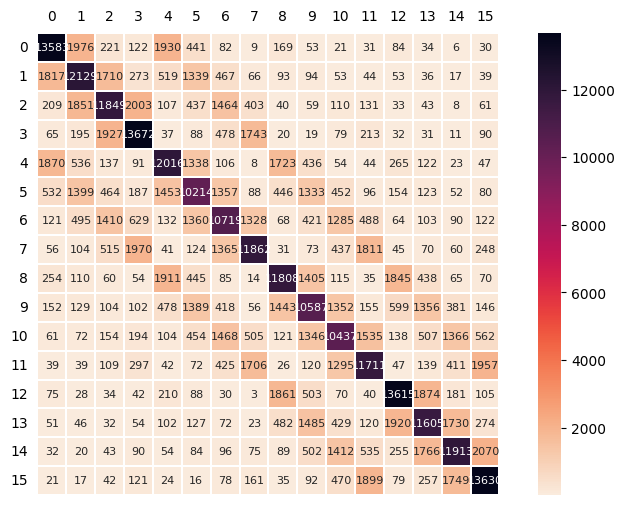

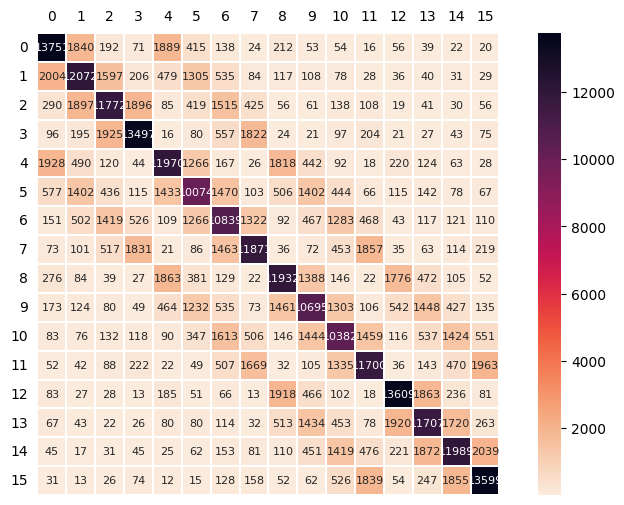

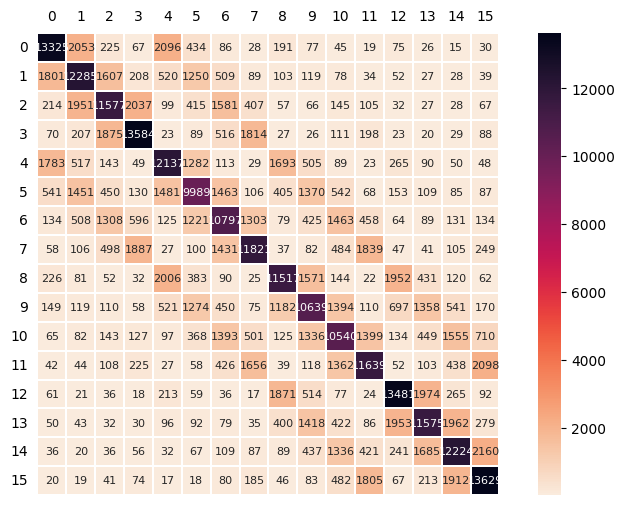

In [ ]:
for i in range(n_redes):
    plot_confusion_matrix(model_QAM[i], X_test, y_test, M, nn=True)
#plot_decision_boundary(modelK, X_train, y_train, legend=True, nn=True)
#plot_decision_boundary(modelK, X_train, y_train, legend=True, nn=True, plot_training=False)

## Avaliação do modelo em diferentes faixas de relação sinal/ruído

### QAM | Rayleigh

In [17]:
Mod = "QAM"
channel_type = "rayleigh"
M = 16
init_scale = 2
interval = 18
passo = 1

In [18]:
Teo_SNRs = [theoretical_error(Mod, M, init_scale + i, channel_type) for i in range(0, interval, passo)]

In [36]:
error_rate = ([[error(int(200 / (Teo_SNRs[int(i / passo)] * np.log2(M))), model_QAM[j], Mod, M, channel_type, Es, code_rate, [init_scale + i]) for i in range(0, interval, passo)] for j in range(n_redes)]) / (tf.math.log(float(M))/tf.math.log(2.))

In [38]:
amostras = [conjunto(Mod, int(200 / (Teo_SNRs[int(i / passo)] * np.log2(M))), M, channel_type, Es, code_rate, [init_scale + i], False, scaler.transform) for i in range(0, interval, passo)]

In [37]:
error_rate

<tf.Tensor: shape=(3, 18), dtype=float32, numpy=
array([[0.17298578, 0.16888888, 0.16286308, 0.14272031, 0.13947369,
        0.1031746 , 0.12571023, 0.10113066, 0.09010989, 0.07794677,
        0.07043974, 0.05896552, 0.04861111, 0.03925819, 0.03162291,
        0.03049576, 0.02539894, 0.02040155],
       [0.17654029, 0.16666667, 0.15456432, 0.15517241, 0.13421053,
        0.1388889 , 0.10866477, 0.10301507, 0.09010989, 0.08365019,
        0.06962541, 0.06413793, 0.05063657, 0.04238921, 0.03659507,
        0.02511415, 0.02101064, 0.02223662],
       [0.1872038 , 0.18444444, 0.16908714, 0.13793103, 0.14035088,
        0.12142857, 0.10014205, 0.09359296, 0.0945055 , 0.07652091,
        0.07003257, 0.05655172, 0.05150463, 0.04046243, 0.03639618,
        0.0301696 , 0.02566489, 0.01943005]], dtype=float32)>

In [39]:
error_rate = ([[ser(model_QAM[j], tf.reshape(tf.convert_to_tensor(amostras[i][0]), [-1, 3]),
                              tf.reshape(tf.convert_to_tensor(amostras[i][1]), [-1, 1]), nn=True)
              for i in range(len(amostras))] for j in range(n_redes)]) / (tf.math.log(float(M))/tf.math.log(2.))

In [40]:
error_rate

<tf.Tensor: shape=(3, 18), dtype=float32, numpy=
array([[0.17417061, 0.19222222, 0.14315353, 0.14655173, 0.13947369,
        0.13015874, 0.109375  , 0.1048995 , 0.08461539, 0.0803232 ,
        0.06636808, 0.05896552, 0.04947917, 0.04118497, 0.02983293,
        0.02201566, 0.02340426, 0.0224525 ],
       [0.17535545, 0.18777777, 0.14211619, 0.14846744, 0.14122806,
        0.13095239, 0.11008523, 0.10364322, 0.08461539, 0.07794677,
        0.06718241, 0.05827586, 0.05092593, 0.04214836, 0.03003182,
        0.02348337, 0.02473404, 0.0224525 ],
       [0.17417061, 0.19111112, 0.14419088, 0.14655173, 0.1377193 ,
        0.12857144, 0.11008523, 0.10615578, 0.08516484, 0.0803232 ,
        0.06636808, 0.05827586, 0.05034722, 0.03998073, 0.02943516,
        0.02348337, 0.02367021, 0.02083333]], dtype=float32)>

In [37]:
np.mean(error_rate - Teo_SNRs)

-0.021166965

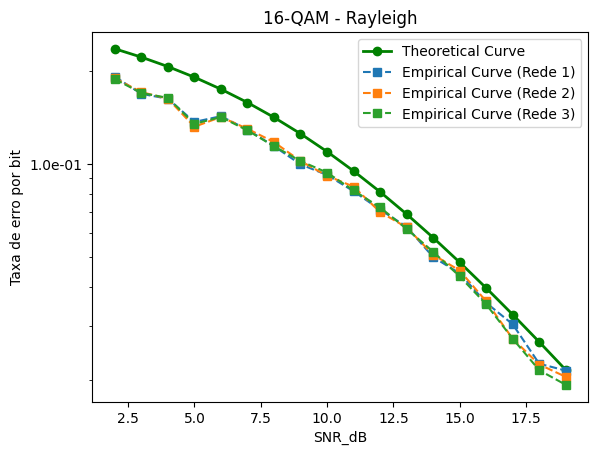

In [38]:
import matplotlib.ticker as tick

y1 = Teo_SNRs
x = range(init_scale, init_scale + interval, passo)

fig, ax = plt.subplots(1,1)

ax.plot(x, y1, 'go-', label='Theoretical Curve', linewidth=2)
[ax.plot(x, error_rate[i], 's--', label=f'Empirical Curve (Rede {i + 1})') for i in range(n_redes)]

ax.set_title('16-QAM - Rayleigh')
ax.set_xlabel('SNR_dB')
ax.set_ylabel('Taxa de erro por bit')

def y_fmt(x, y):
    return '{:2.1e}'.format(x)

ax.set_yscale("log")
ax.yaxis.set_major_formatter(tick.FuncFormatter(y_fmt))
#plt.plot(x2, y2, 'rs--',  label='line 2')

plt.legend()
plt.show()

## QAM AWGN

In [6]:
total_num_symbols  = 1000000    # Number of transmitted symbols to be used for training and test
train_fraction = 0.7 # Fraction of whole data to be used for training (the remaining is for testing)
code_rate    = 1       # Rate of the used code
Es           = 1       # Average symbol energy
Mod = 'QAM'
channel_type = 'awng' # 'awgn' or 'crazy'
M            = 16      # PSK modulation

In [7]:
x_out = np.fromfile('Random_Data/SNR_8-12/AWGN/16-QAM/x_rand.dat', dtype=np.dtype('float64')).reshape((-1,3))
y_out = np.fromfile('Random_Data/SNR_8-12/AWGN/16-QAM/y_rand.dat', dtype=np.dtype('float64'))
symbs = np.fromfile('Random_Data/SNR_8-12/AWGN/16-QAM/symb.dat', dtype=np.dtype('complex128')).reshape((1,-1))

In [8]:
# Generate dataset
# Train
train_size = int(train_fraction*total_num_symbols) #data used for training
y_train = y_out[:train_size]
X_train = x_out[:train_size]

# Test
y_test = y_out[train_size:]
X_test = x_out[train_size:]

scaler = StandardScaler()
scaler.fit(X_train)  # Don't cheat - fit only on training data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)



KeyboardInterrupt



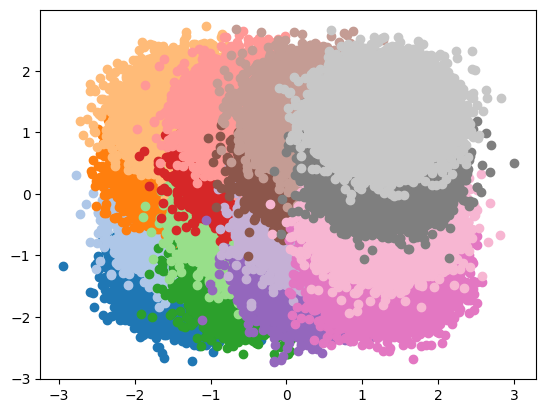

In [44]:
plot_symbols(X_train, y_train, M, symbs)

## Criação e treinamento da Rede Neural

In [9]:
n_inputs = np.shape(X_train)[1]

In [10]:
n_redes = 3
n_hidden = [[150, 80, 50],
            [300, 180, 90, 40],
            [500, 380, 240, 135, 80]]

n_outputs = M
learning_rate = [0.01, 0.01, 0.001]
n_epochs = [50, 50, 50]
batch_size = [8000, 16000, 24000]
momentum = [0.7, 0.8, 0.9]

In [11]:
y_train = tf.reshape(tf.convert_to_tensor(y_train), [-1, 1])
y_test = tf.reshape(tf.convert_to_tensor(y_test), [-1, 1])
X_test = tf.convert_to_tensor(X_test)
X_train = tf.convert_to_tensor(X_train)

2023-04-10 10:59:29.432444: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-10 10:59:29.433209: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-10 10:59:29.433270: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (keko-ubuntu): /proc/driver/nvidia/version does not exist
2023-04-10 10:59:29.439783: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Usando API Keras

In [12]:
inputs = tf.keras.Input(shape=(n_inputs,))
output = []

for i in range(n_redes):
    x = inputs
    for j in range(len(n_hidden[i])):
        x = tf.keras.layers.Dense(n_hidden[i][j], activation="elu", kernel_initializer="glorot_normal")(x)
    output.append(tf.keras.layers.Dense(n_outputs, kernel_initializer="glorot_normal")(x))
    del x

In [13]:
model_QAM = []
for i in range(n_redes):
    model_QAM.append(tf.keras.Model(inputs=inputs, outputs=output[i]))
    
    model_QAM[i].summary()

    model_QAM[i].compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=learning_rate[i], momentum=momentum[i], nesterov=True),
                 metrics=["accuracy"])

    history = model_QAM[i].fit(X_train, y_train, batch_size=batch_size[i], epochs=n_epochs[i], shuffle=True)

    tests_score = model_QAM[i].evaluate(X_test, y_test)
    print("\nTest loss:", tests_score[0])
    print("Test accuracy:", tests_score[1])
    print(f"Taxa de erro simbólica de {(1 - tests_score[1]):.2%}\n")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense (Dense)               (None, 150)               600       
                                                                 
 dense_1 (Dense)             (None, 80)                12080     
                                                                 
 dense_2 (Dense)             (None, 50)                4050      
                                                                 
 dense_3 (Dense)             (None, 16)                816       
                                                                 
Total params: 17,546
Trainable params: 17,546
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
88/88 [==============================] - 3s 22

2023-04-10 11:07:18.979053: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 48000000 exceeds 10% of free system memory.
2023-04-10 11:07:19.019261: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 36480000 exceeds 10% of free system memory.
2023-04-10 11:07:19.211198: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 36480000 exceeds 10% of free system memory.
2023-04-10 11:07:19.274379: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 48000000 exceeds 10% of free system memory.


 1/30 [>.............................] - ETA: 32s - loss: 2.7192 - accuracy: 0.0950

2023-04-10 11:07:19.499401: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 48000000 exceeds 10% of free system memory.


30/30 [==============================] - 16s 518ms/step - loss: 2.6255 - accuracy: 0.1369
Epoch 2/50
30/30 [==============================] - 16s 540ms/step - loss: 2.3712 - accuracy: 0.2975
Epoch 3/50
30/30 [==============================] - 17s 553ms/step - loss: 2.1420 - accuracy: 0.3309
Epoch 4/50
30/30 [==============================] - 18s 585ms/step - loss: 1.9374 - accuracy: 0.3716
Epoch 5/50
30/30 [==============================] - 17s 564ms/step - loss: 1.7612 - accuracy: 0.4274
Epoch 6/50
30/30 [==============================] - 17s 571ms/step - loss: 1.6160 - accuracy: 0.5069
Epoch 7/50
30/30 [==============================] - 18s 589ms/step - loss: 1.4981 - accuracy: 0.5513
Epoch 8/50
30/30 [==============================] - 17s 574ms/step - loss: 1.4009 - accuracy: 0.5774
Epoch 9/50
30/30 [==============================] - 17s 572ms/step - loss: 1.3184 - accuracy: 0.6004
Epoch 10/50
30/30 [==============================] - 17s 581ms/step - loss: 1.2470 - accuracy: 0.6225


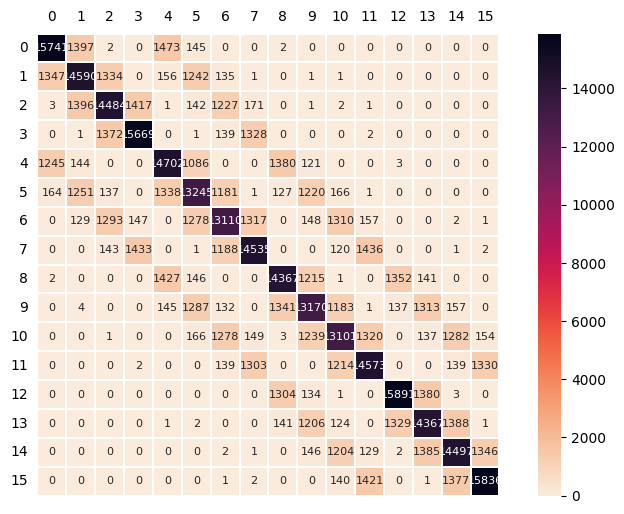

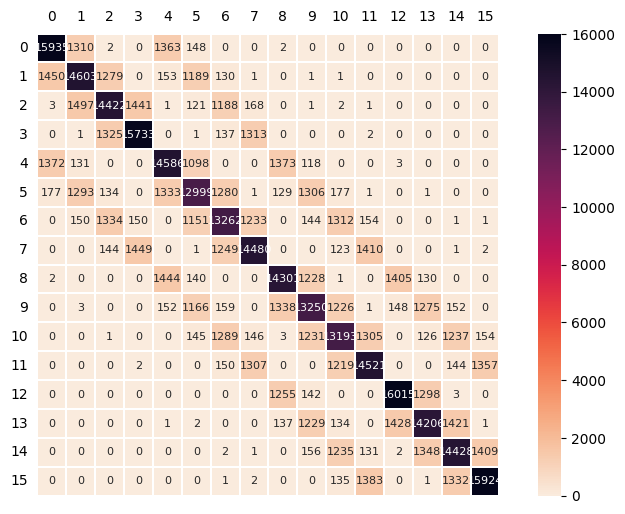

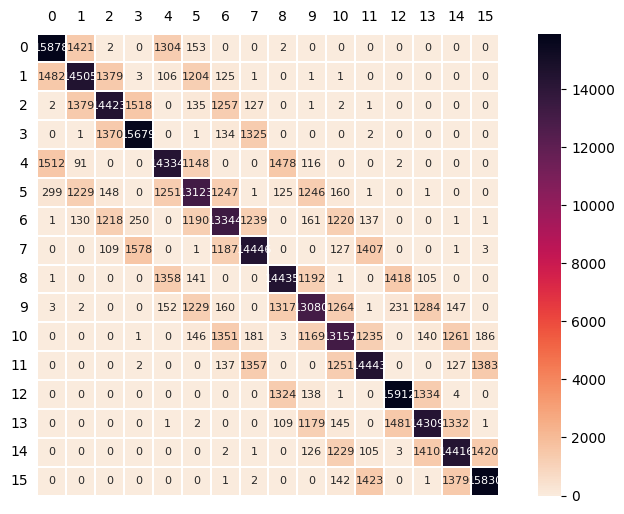

In [14]:
for i in range(n_redes):
    plot_confusion_matrix(model_QAM[i], X_test, y_test, M, nn=True)
#plot_decision_boundary(modelK, X_train, y_train, legend=True, nn=True)
#plot_decision_boundary(modelK, X_train, y_train, legend=True, nn=True, plot_training=False)

## Avaliação do modelo em diferentes faixas de relação sinal/ruído

### QAM | AWGN

In [26]:
Mod = "QAM"
channel_type = "awgn"
M = 16
init_scale = 2
interval = 28
passo = 1

In [27]:
Teo_SNRs = [theoretical_error(Mod, M, init_scale + i, channel_type) for i in range(0, interval, passo)]

In [17]:
amostras = [conjunto(Mod, int(100 / (Teo_SNRs[int(i / passo)] * np.log2(M))), M, channel_type, Es, code_rate, [init_scale + i], False, scaler.transform) for i in range(0, interval, passo)]

In [ ]:
error_rate = ([[error(int(100 / (Teo_SNRs[int(i / passo)] * np.log2(M))), model_QAM[j], Mod, M, channel_type, Es, code_rate, [init_scale + i]) for i in range(0, interval, passo)] for j in range(n_redes)]) / (tf.math.log(float(M))/tf.math.log(2.))

In [18]:
error_rate = ([[ser(model_QAM[j], tf.reshape(tf.convert_to_tensor(amostras[i][0]), [-1, 3]),
                              tf.reshape(tf.convert_to_tensor(amostras[i][1]), [-1, 1]), nn=True)
              for i in range(len(amostras))] for j in range(n_redes)]) / (tf.math.log(float(M))/tf.math.log(2.))

In [ ]:
error_rate

In [20]:
np.mean(error_rate - Teo_SNRs)

-0.002495486

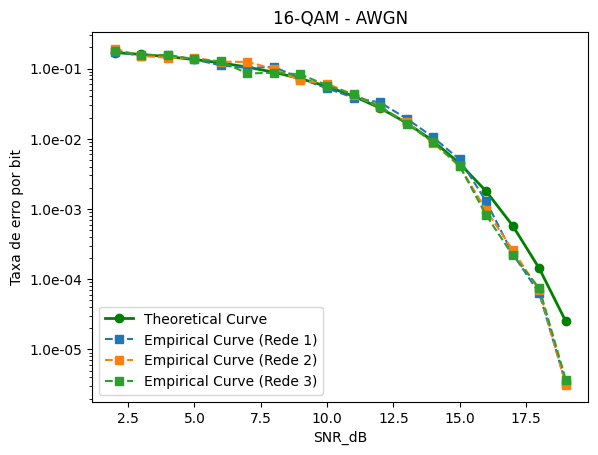

In [25]:
import matplotlib.ticker as tick

y1 = Teo_SNRs
x = range(init_scale, init_scale + interval, passo)

fig, ax = plt.subplots(1,1)

ax.plot(x, y1, 'go-', label='Theoretical Curve', linewidth=2)
[ax.plot(x, error_rate[i], 's--', label=f'Empirical Curve (Rede {i + 1})') for i in range(n_redes)]

ax.set_title('16-QAM - AWGN')
ax.set_xlabel('SNR_dB')
ax.set_ylabel('Taxa de erro por bit')

def y_fmt(x, y):
    return '{:2.1e}'.format(x)

ax.set_yscale("log")
ax.yaxis.set_major_formatter(tick.FuncFormatter(y_fmt))
#plt.plot(x2, y2, 'rs--',  label='line 2')

plt.legend()
plt.show()